The first goal is to reproduce the calculation of the PH bubble - Lindhard function - using triqs_tprf package. 
Then we go from bubble (susceptibility) to vertex (interaction) and back using Einstein's summation notation.

In [2]:
from triqs.gf import *
from triqs.plot.mpl_interface import *
from triqs.lattice import *
from triqs.gf.tools import *
from triqs_tprf.lattice import lattice_dyson_g0_wk
from triqs_tprf.lattice import lattice_dyson_g_wk
# from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk
from triqs_tprf.tight_binding import TBLattice
import numpy as np
from scipy.integrate import quad
import gc

pi = np.pi
g = 1.0


Starting serial run at: 2023-11-26 16:39:50.197190


In [2]:
t = 1.0
H = TBLattice(
    units = [(1, 0, 0), (0, 1, 0)],
    hopping = {
        # nearest neighbour hopping -t
        ( 0,+1): -t * np.eye(2),
        ( 0,-1): -t * np.eye(2),
        (+1, 0): -t * np.eye(2),
        (-1, 0): -t * np.eye(2),
        },
    orbital_positions = [(0,0,0)]*2,
    orbital_names = ['up', 'do'],
    )

kmesh = H.get_kmesh(n_k=(32, 32, 1))

e_k = H.fourier(kmesh)


In [3]:

wmesh = MeshImFreq(beta=5.0, S='Fermion', n_max=30)
g0_wk = lattice_dyson_g0_wk(mu=0., e_k=e_k, mesh=wmesh)
chi00_wk = imtime_bubble_chi0_wk(g0_wk, nw=1)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 5.0
nk    = 1024
nw    = 60
norb  = 2

Approx. Memory Utilization: 0.01 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_w0r_from_grt_PH (bubble in tau & r)
--> chi_wk_from_chi_wr (r->k)


In [154]:
chi00_wk

Greens Function  with mesh Matsubara Freq Mesh of size 1, Domain: Matsubara domain with beta = 5, statistic = Boson, positive_only : 0, Brillouin Zone Mesh with linear dimensions (32 32 1)
 -- units = 
[[0.19635,0,0]
 [0,0.19635,0]
 [0,0,6.28319]]
 -- periodization_matrix = 
[[32,0,0]
 [0,32,0]
 [0,0,1]]
 -- Domain: Brillouin Zone with 2 dimensions and reciprocal matrix 
[[6.28319,0,0]
 [0,6.28319,0]
 [-0,-0,6.28319]] and target_shape (2, 2, 2, 2): 

In [3]:
trial_vertex= g**2 * chi00_wk[Idx(0),:]
bubble = chi00_wk

In [28]:
# get susceptibility from bubble

# define a numpy array containing four Pauli matrices
sigma = np.array([np.eye(2), np.array([[0, 1], [1, 0]]), np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]])])

# trace over the bubble with the Pauli matrices to get the four susceptibilities
# create a copy of the bubble with an extra axis spanning the Pauli matrices
chi = [bubble[0,0,0,0].copy() for i in range(4)]
for i in range(4):
    chi[i].data[:] = np.einsum('wqabcd,ab,cd->wq', bubble.data, sigma[i], sigma[i])

In [5]:
# Now get the bubble from the susceptibility

# create a Green's function with the same mesh as chi[0] but target_shape = 2,2,2,2
bubble2 = Gf(mesh=chi[0].mesh, target_shape=[2,2,2,2])
bubble2.zero()

# fill its data with outer products of Pauli matrices stored in sigma multiplied by the corresponding susceptibilities stored in chi
for i in range(4):
    bubble2.data[:] += 1/4* np.einsum('wq,ab,cd->wqabcd', chi[i].data, sigma[i], sigma[i])

# Now check that bubble2 is the same as bubble
np.allclose(bubble.data.real, bubble2.data.real)


True

In [6]:
# check whether the susceptibility is chi is different for the four indices
print(np.allclose(chi[0].data.real, chi[1].data.real))
print(np.allclose(chi[0].data.real, chi[1].data.real))
print(np.allclose(chi[0].data.real, chi[2].data.real))
print(np.allclose(chi[0].data.imag, chi[1].data.imag))
print(np.allclose(chi[0].data.imag, chi[1].data.imag))
print(np.array_equal(chi[0].data.imag, chi[2].data.imag))


True
True
True
True
True
True


It turns out that the charge and spin susceptibility are indeed same at the non-interacting level.

The next step is to load the susceptibility data from the functional form in Dahm et al into Green's function form, and compute a vertex function from it, with a single free parameter - the coupling strength U. The vertex function is a Gf object with the same structure as bubble. 

Note : lattice size and discretization defined here

In [3]:
n_w = 121
wmesh = MeshReFreq(window = (0.,120.), n_w = n_w)

BL = BravaisLattice([(1,0,0),(0,1,0)])
BZ = BrillouinZone(BL)
n_k = 16
kmesh = MeshBrZone(BZ, n_k = n_k)

kwmesh = MeshProduct(kmesh, wmesh)

In [4]:
# define functions to transform between k and HKL
def k_to_HKL(k):
    return k @ np.linalg.inv(kmesh.domain.units)
k_to_HKL([2*pi,0.,0.])
def HKL_to_k(HKL):
    return HKL @ kmesh.domain.units

In [4]:
import math
import latexify

In [5]:
@latexify.function
def solve(a, b, c):
  return (-b + math.sqrt(b**2 - 4*a*c)) / (2*a)


In [6]:
print(solve(1, 4, 3))  # Invoking the function works as expected.
print(solve)  # Printing the function shows the underlying LaTeX expression.
solve  # Display the MathJax.

-1.0
\mathrm{solve}(a, b, c) = \frac{-b + \sqrt{ b^{2} - 4 a c }}{2 a}


In [5]:
# Now define a fit function for the susceptibility


#constants
N0l = 0.001807; sigma_a = 0.125; sigma_b = 0.17; Q_0a = 0.5; Q_0b = 0.5+0.0001; #this is so that the lattice is not non-analytic at Q_0
Q_1a = 0.575; Q_1b = 0.5; Q_2a = 0.425; Q_2b = 0.5; Gamma = 11.0; p = 4; S_a = 4830.0; S_b = 10065.0; N0u = 1.35; w_dip = 47.0; sigma_dip = 2.0; N0 = 1.; Omega_r = 38.5; 
# N.B. S_a and S_b are defined in the paper as S_a = 4830.0 meV Angstrom^4 and S_b = 10065.0 meV Angstrom^4 respectively, but in our code we take the lattice constant to be unity
@latexify.function
def lower_fit_function(Qa, Qb, w):
    term1 = np.exp(-4 * np.log(2) * (((Qa - Q_1a) / sigma_a) ** 2 + ((Qb - Q_1b) / sigma_b) ** 2))
    term2 = np.exp(-4 * np.log(2) * (((Qa - Q_2a) / sigma_a) ** 2 + ((Qb - Q_2b) / sigma_b) ** 2))
    return N0 * N0l * Nlin(w) * Nl(w) * NL(w) * (term1 + term2)

def Nl(w):
    return 1 - 0.5/(1 + np.exp(w - 29.5)/2) #half ampltiude filter below 29.5 meV to half strength with a width of 2 meV

def NL(w):
    return 1/(1 + np.exp(w - 37)/2) #cut off at 37 meV with a width of 2 meV

def Nlin(w):
    if w >= 27:
        return 1
    else:
        return w/27
    
@latexify.function    
def upper_fit_function(Qa, Qb, w):
    return N0 * N0u * Nu(w) * Ndip(w) * Nrot(Qa,Qb) * (2*w*Gamma)/((w**2 - disp(Qa,Qb)**2)**2 + (2*w*Gamma)**2)

def disp(Qa, Qb):
    term1 = S_a**(2/p) * (Qa - Q_0a)**2
    term2 = S_b**(2/p) * (Qb - Q_0b)**2
    Omega_Q = Omega_r + (term1 + term2)**(p/2)
    return Omega_Q

def Nu(w):
    return 1 - 1.02/(1 + np.exp(w - 37)/2) #1 - 1/(1 + np.exp(w - 36)/1.5) #cut off below 36 meV with a width of 1.5 meV

def Ndip(w):
    return 1 #1 - 0.2 * np.exp(-(w-w_dip)**2 / (2 * sigma_dip**2))

def Nrot(Qa, Qb):
    return 1 - 0.3 * (((Qa - Q_0a)**2 - (Qb - Q_0b)**2) / ((Qa - Q_0a)**2 + (Qb - Q_0b)**2))**2

fit_function = np.vectorize(lambda Qa, Qb, w: lower_fit_function(Qa, Qb, w) + upper_fit_function(Qa, Qb, w))

# latexify.get_latex(upper_fit_function)

lower_fit_function
upper_fit_function
# try this later after restarting the kernel


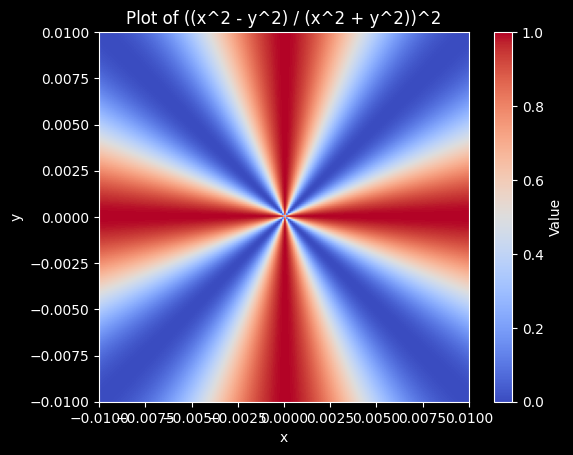

In [191]:
# shows the non-analyticity at Q_0 due to the factor N_rot
x_range = np.arange(-0.01, 0.01, 0.0001)
y_range = np.arange(-0.01, 0.01, 0.0001)
Z = np.array([(((x)**2 - (y)**2) / ((x)**2 + (y)**2))**2 for x in x_range for y in y_range])
Z = Z.reshape(len(x_range), len(y_range))
plt.imshow(Z, extent=[-0.01, 0.01, -0.01, 0.01], origin='lower', cmap='coolwarm')
plt.colorbar(label='Value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of ((x^2 - y^2) / (x^2 + y^2))^2')
plt.show()


In [6]:
# load the experimental data into chi_expt, a ReFreq Gf with target_shape = [] 
chi_expt = Gf(mesh = kwmesh, target_shape = [])

for k, w in kwmesh:
    k_HKL = k.value/(2 * pi) #k.value @ np.linalg.inv(kmesh.domain.units)
    chi_expt[k,w] = fit_function(k_HKL[0], k_HKL[1], w.value)

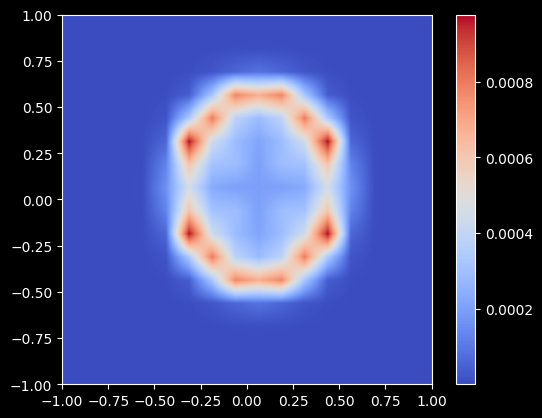

In [755]:
# Now plot the experimental data at a given energy

# Prepare the data
n_kpath=kmesh.dims[0]
k_grid = k_arr.reshape(n_kpath,n_kpath,3)
X = k_grid[...,0]/pi
Y = k_grid[...,1]/pi
# Z = eps_k.data.reshape(n_kpath,n_kpath)


# Plot the dispersion
plt.imshow(chi_expt.data.real.reshape(n_kpath,n_kpath,121)[...,60], origin='lower', extent=[-1,1,-1,1], cmap='coolwarm',interpolation='bilinear',interpolation_stage='data')
plt.colorbar()

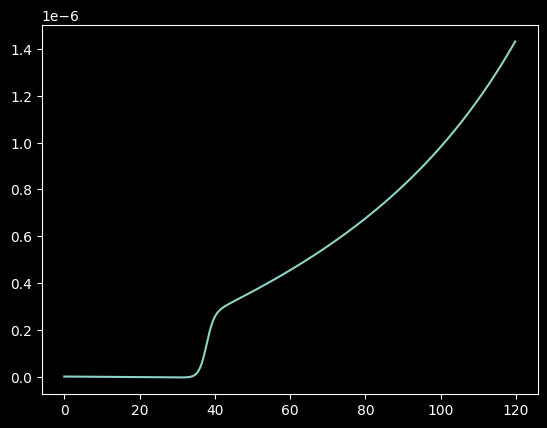

In [756]:
#plot the fit_function over freq
w_range = np.arange(0, 120, 0.2)
plt.plot(w_range, list(map(lambda w: fit_function(0.05,0.5, w), w_range)))


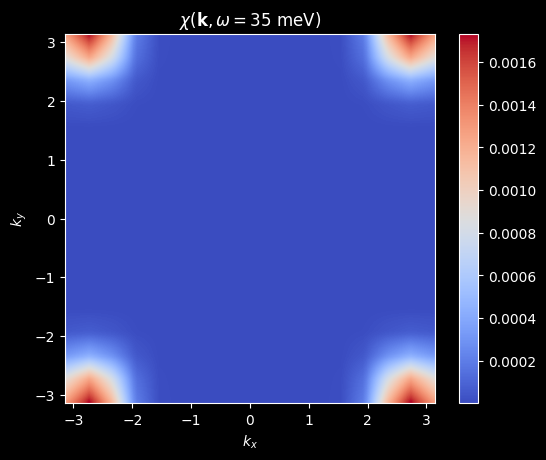

In [757]:
# extract chi_expt at w=35meV
#chi_real = np.real(chi_expt((kmesh, 0)))

kx = np.linspace(-np.pi, np.pi, 100)
ky = np.linspace(-np.pi, np.pi, 100)
kx, ky = np.meshgrid(kx, ky)

w_probe = 35
chi_real = np.copy(kx)
for i in range(len(kx)):
    for j in range(len(kx)):
        chi_real[i,j] = chi_expt((kx[i,j], ky[i,j], 0.),w_probe).real


plt.imshow(chi_real, extent=[-pi,pi,-pi,pi], cmap='coolwarm', origin='lower', interpolation='bilinear', interpolation_stage='data')
plt.colorbar()
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.title(r'$\chi(\mathbf{k},\omega = $'+str(w_probe)+' meV)')
plt.show()


In [49]:
kwmesh =  MeshProduct(kmesh, wmesh)

G = Gf(mesh=kwmesh, target_shape=[])
G((pi,pi,0), 2)

0j

In [51]:
wkmesh =  MeshProduct(wmesh, kmesh)
del G
G = Gf(mesh=wkmesh, target_shape=[])
G(2, (pi,pi,0))

TypeError: __call__() takes 2 positional arguments but 3 were given

^^ This demonstrates an idiosyncracy of the call function of a Green's function defined on a MeshProduct. It works only if the mesh is a product of MeshBrZone and MeshReFreq and does not work if the order is reversed.

([<matplotlib.axis.XTick at 0x7f43a2a01250>,
 [Text(0, 0, '(0,0)'),
  Text(100, 0, '(π,0)'),
  Text(200, 0, '(π,π)'),
  Text(300, 0, '(0,0)')])

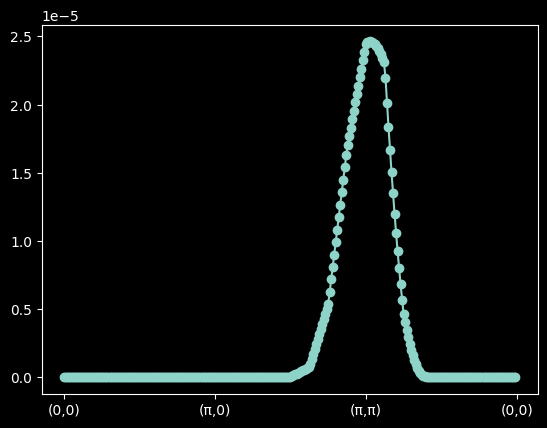

In [1059]:
# plot chi_expt at w=35meV along Gamma-X-M-Gamma

# w_probe = 10
# chi_expt_cut_real = np.zeros(len(k_vecs))
# chi_expt_cut_imag = np.zeros(len(k_vecs))
# for id, k in enumerate(k_vecs):
#     chi_expt_cut_real[id] = chi_expt((k[0],k[1], 0.),w_probe).real
#     chi_expt_cut_imag[id] = chi_expt((k[0],k[1], 0.),w_probe).imag
# plt.plot(k_plot, chi_expt_cut_real, '-', label='Real')
# plt.plot(k_plot, chi_expt_cut_imag, '-', label='Imaginary')
# plt.xticks(k_ticks, [r'$\Gamma$',r'$X$',r'$M$',r'$\Gamma$'])
# plt.title(r'$\chi(\mathbf{k},\omega = $'+str(w_probe)+' meV)')
# plt.legend()
# plt.grid(True)
# plt.show()


# First we need to define the path
path = np.array([ (0,0,0), (pi,0,0), (pi,pi,0)])

# Now we need to define the k-mesh along the path
n_kpath = 100
kmesh_path = np.zeros((3*n_kpath, 3))
for i in range(n_kpath):
    kmesh_path[i] = i * (path[1] - path[0]) / n_kpath
    kmesh_path[i + n_kpath] = path[1] + i * (path[2] - path[1]) / n_kpath
    kmesh_path[i + 2*n_kpath] = path[2] + i * (path[0] - path[2]) / n_kpath

w_probe = 1
chi_cut = np.zeros(len(kmesh_path))
for id, k in enumerate(kmesh_path):
    chi_cut[id] = chi_expt((k[0],k[1], 0.),w_probe).real

plt.plot(chi_cut, 'o-')
plt.xticks([i*n_kpath for i in range(4)], ['(0,0)', '(π,0)', '(π,π)', '(0,0)'])




Next we have to define the dressed Green's function, using the Dyson equation, and the vertex function given by the experimentally measured susceptibility.

Then we have to define the particle-particle vertex function, from the particle-hole vertex function.

With these ingredients, we now try out the solve_Eliashberg function, and plot the largest eigenvector.

For the first part, we need 
1) the bare Green's function
2) the susceptibility in imaginary frequency, to make a vertex
3) the self-energy from the vertex and the bare Green's function

Then we get the dressed Green's function from the Dyson equation.

In [7]:
# Next setup a tight binding model for the cuprates, with nearest neighbour hopping t, next nearest neighbour hopping t', and next next nearest neighbour hopping t''. It must have two bands per spin, for bonding and antibonding states.

TA=409;TB=550;TPA=150;TPB=231;TPPA=40;TPPB=67;MUA=556;MUB=417
H = TBLattice(
    units = [(1, 0, 0), (0, 1, 0)],
    hopping = {
        # chemical potential
        ( 0, 0): np.diag([MUA,MUA,MUB,MUB]),
        # nearest neighbour hopping -t
        ( 0,+1): -np.diag([TA,TA,TB,TB]),
        ( 0,-1): -np.diag([TA,TA,TB,TB]),
        (+1, 0): -np.diag([TA,TA,TB,TB]),
        (-1, 0): -np.diag([TA,TA,TB,TB]),
        # next nearest neighbour hopping -t'
        (+1,+1): -np.diag([TPA,TPPA,TPB,TPPB]),
        (+1,-1): -np.diag([TPA,TPPA,TPB,TPPB]),
        (-1,+1): -np.diag([TPA,TPPA,TPB,TPPB]),
        (-1,-1): -np.diag([TPA,TPPA,TPB,TPPB]),
        # next next nearest neighbour hopping -t''
        (+2, 0): -np.diag([TPPA,TPPA,TPPB,TPPB]),
        (-2, 0): -np.diag([TPPA,TPPA,TPPB,TPPB]),
        ( 0,+2): -np.diag([TPPA,TPPA,TPPB,TPPB]),
        ( 0,-2): -np.diag([TPPA,TPPA,TPPB,TPPB]),
        },
    orbital_positions = [(0,0,0)]*4,
    orbital_names = ['up-bo', 'do-bo', 'up-ab', 'do-ab'],
    )
e_k = H.fourier(kmesh)

/usr/lib/python3.8/dist-packages/triqs_tprf/lattice_utils.py:421: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if interpolator is 'regular':
/usr/lib/python3.8/dist-packages/triqs_tprf/lattice_utils.py:425: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif interpolator is 'nearest':
/usr/lib/python3.8/dist-packages/triqs_tprf/lattice_utils.py:428: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif interpolator is 'linear':


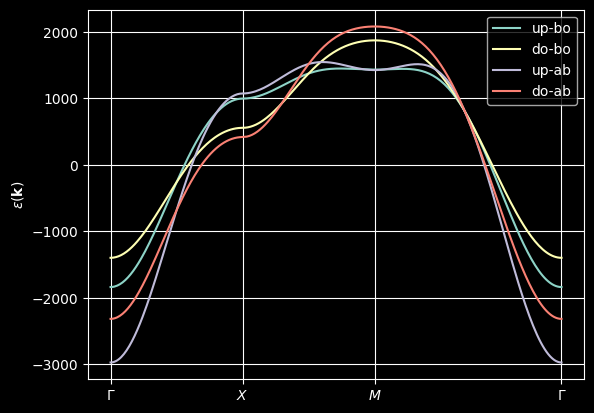

In [10]:
#plots the band structure

# We need to define the k-mesh along the path Gamma to X to M to Gamma
from triqs_tprf.lattice_utils import k_space_path
G=np.array([0,0,0.0])
X=np.array([0.5,0,0])
M=np.array([0.5,0.5,0])
path=[(G,X),(X,M),(M,G)]
k_vecs, k_plot, k_ticks = k_space_path(path)
# Now we can plot the band structure along the path
ek_plot = np.zeros((4,len(k_vecs)))
for i in range(4):
    ek_plot[i] = H.fourier(k_vecs)[:,i,i].real
    plt.plot(k_plot, ek_plot[i], label=H.orbital_names[i])
plt.xticks(k_ticks, [r'$\Gamma$',r'$X$',r'$M$',r'$\Gamma$'])
plt.ylabel(r'$\epsilon(\mathbf{k})$')
plt.legend()
plt.grid(True)

In [8]:
# First we need to define the bare Green's function for the tight binding model
K_B = 8.617333262145e-2 # Boltzmann constant in meV/K
T = 70 # Temperature in Kelvin
n_iw = 1200 # Number of positive Matsubara frequencies

iwmesh = MeshImFreq(beta=1.0/(K_B*T), S='Fermion', n_iw=n_iw)
kiwmesh = MeshProduct(kmesh, iwmesh)

ek=H.fourier(kmesh)
g0_iwk= lattice_dyson_g0_wk(mu=0.0, e_k=H.fourier(kmesh), mesh=iwmesh)

# G0_kiw = Gf(mesh=kiwmesh, target_shape=[4,4])
# for kid,k in enumerate(kmesh):
#     for wid, iw in enumerate(iwmesh):
#         G0_kiw.data[kid,wid,:,:] = np.linalg.inv(iw.value*np.eye(4) - H.fourier(k.value))



In [9]:
iwmesh

Matsubara Freq Mesh of size 2400, Domain: Matsubara domain with beta = 0.165779, statistic = Fermion, positive_only : 0

In [429]:
#must redefine this function g0_iwk so that the output is callable, order: space, time not time, space
G0_kiw = Gf(mesh=kiwmesh, target_shape=[4,4])
# G0_kiw[0,0](np.array([0,0,0]), 1)
for k in kmesh:
    G0_kiw[k,:] << iOmega_n - ek[k]
G0_kiw.invert()

In [435]:
#check that it is defined correctly
g0_kiw_data = np.transpose(g0_iwk.data, (1, 0, 2, 3))
assert np.allclose(g0_kiw_data, G0_kiw.data)

In [463]:
# for future reference, easier way to swap k,w to make it callable
# G0_kiw = Gf(mesh=kiwmesh, data=np.transpose(g0_iwk.data, (1, 0, 2, 3)))
# G0_kiw[0,0](np.array([0,0,0]), 1)
# turns out this is not callable

# Only the local Green's functions defined on time/freq mesh can be assigned by << not the ones defined on k,w mesh, not the one defined on a meshpoint
G0_kiw = Gf(mesh=kiwmesh, target_shape=[4,4])
for k in kmesh:
    G0_kiw[k,:] << g0_iwk[:,k]

In [497]:
print(H.fourier(M)[0,0])
print(H.fourier(M+np.array([1,0,0]))[0,0])

(1432+0j)
(1432+0j)


In [498]:
ek=H.fourier(kmesh)
print(ek(M)[0,0])
print(ek(M+[2*pi,0.,0.])[0,0])

(-1415.2943536363355+0j)
(-1415.2943536363357+0j)


^^ This exhibits another idiosyncrasy of the TRIQS implementation. fourier takes a BrZone MeshPoint and returns a Gf object, stored in ek,which can be called with a numpy array [kx,ky,kz]. But fourier is also overloaded as a function which takes a numpy array [H,K,L] (coefficients of RL vectors) and returns a numpy array hk. These two implementations have different periodicities. All calls to Gf objects follow the first convention. 

In [507]:
print(G0_kiw[0,0](HKL_to_k(M),0))
print(G0_kiw[0,0](HKL_to_k(M+np.array([1,0,0])),0))

(-1432+0.05j)
(-1432+0.05j)


1\) the bare Green's function => g0_iwk ☑️

Now we move on to 2) the susceptibility in imaginary frequency


In [9]:
def chiGamma(w):
    return fit_function(0.,0.,w)

def chiX(w):
    return fit_function(0.5,0.,w)

def chiM(w):
    return fit_function(0.5,0.5,w)


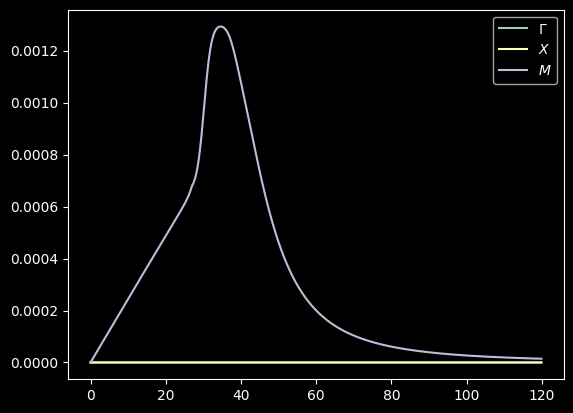

In [17]:
#plot the w-dependence of the susceptibility at Gamma, X, and M

w_range = np.arange(0, 120, 0.1)
plt.plot(w_range, list(map(lambda w: chiGamma(w), w_range)), label=r'$\Gamma$')
plt.plot(w_range, list(map(lambda w: chiX(w), w_range)), label=r'$X$')
plt.plot(w_range, list(map(lambda w: chiM(w), w_range)), label=r'$M$')
# plt.xlim(0,20)
plt.legend()

In [10]:
# load the experimental data into a Gf with target_shape = [] defined on kiOmesh
from tqdm import tqdm
iOmesh=MeshImFreq(beta=1.0/(K_B*T), S='Boson', n_max=n_iw+1)
kiOmesh = MeshProduct(kmesh, iOmesh)
chi_expt_kiO = Gf(mesh = kiOmesh, target_shape = [], name=r'$\chi_expt$')
relerr = Gf(mesh = kiOmesh, target_shape = [], name=r'$\delta\chi_expt$')


Careful: the next cell takes about 1 hr to run on my laptop (might take 10x more since n_iw=1200 instead of 120). Output is saved to file in the next cell.

In [13]:

#code to store the relative error of the integral in relerr and the value of the integral 
for k, iO in tqdm(kiOmesh):
    HKL= k_to_HKL(k.value)
    val, error = quad(lambda w: fit_function(HKL[0],HKL[1],w)/(iO.value-w)/pi,0,120,complex_func=True)
    chi_expt_kiO[k,iO] = val
    relerr[k,iO] = abs(error)/abs(val)
    

# for n in np.arange(-120, 121):
#     val,err=quad(lambda w: fit_function(0.0,0.5,w)/(2j*pi*K_B*T*n - w)/pi,0,120,complex_func=True)
#     relerr[120+n]=abs(err)/abs(val)

100%|██████████| 61696/61696 [10:08<00:00, 101.44it/s]


In [15]:
from h5 import HDFArchive
with HDFArchive('chi_expt.h5', 'w') as f:
    f['chi_expt'] = chi_expt_kiO
    f['relerr'] = relerr
    

In [11]:
from h5 import HDFArchive
with HDFArchive('chi_expt.h5', 'r') as f:
    chi_expt_kiO << f['chi_expt'] 
    relerr << f['relerr']

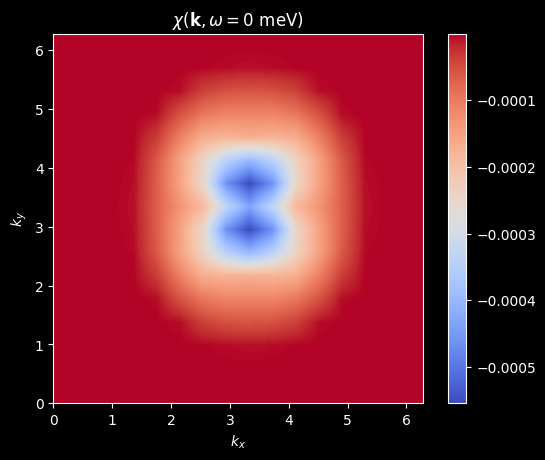

In [25]:
#plot of the susceptibility at w=0 over the BZ
plt.imshow(chi_expt_kiO.data.real.reshape(n_k,n_k,2*n_iw+1)[...,n_iw], extent=[0,2*pi,0,2*pi], origin='lower', cmap='coolwarm',interpolation='bilinear',interpolation_stage='data')
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.title(r'$\chi(\mathbf{k},\omega = $'+str(0)+' meV)')
plt.colorbar()

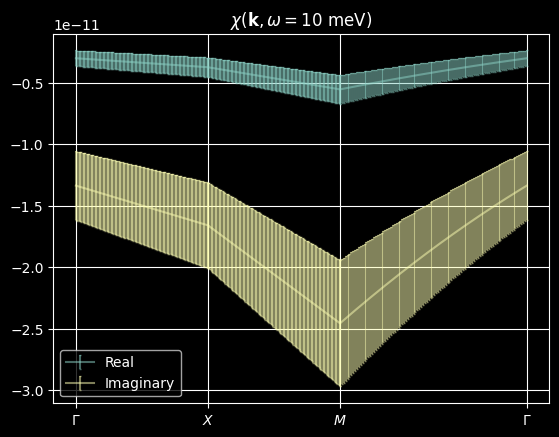

In [26]:
# Next plot a cut of the experimental data at a given frequency as a function of k along the path (0,0) -> (pi,0) -> (pi,pi)  -> (0,0) with error bars from relerr
#this is just wrong needs to be fixed, the data should be smooth at M and X 

w_probe = 10
chi_expt_cut_real = np.zeros(len(k_vecs))
chi_expt_cut_imag = np.zeros(len(k_vecs))
chi_expt_cut_real_err = np.zeros(len(k_vecs))
chi_expt_cut_imag_err = np.zeros(len(k_vecs))
for id, k in enumerate(k_vecs):
    k=k_to_HKL(k)
    chi_expt_cut_real[id] = chi_expt_kiO((k[0],k[1], 0.),w_probe).real
    chi_expt_cut_imag[id] = chi_expt_kiO((k[0],k[1], 0.),w_probe).imag
    chi_expt_cut_real_err[id] = relerr((k[0],k[1], 0.),w_probe).real*abs(chi_expt_cut_real[id])
    chi_expt_cut_imag_err[id] = relerr((k[0],k[1], 0.),w_probe).real*abs(chi_expt_cut_imag[id])
plt.errorbar(k_plot, chi_expt_cut_real, yerr=chi_expt_cut_real_err, fmt='-', label='Real', capsize=1, alpha=0.5)
plt.errorbar(k_plot, chi_expt_cut_imag, yerr=chi_expt_cut_imag_err, fmt='-', label='Imaginary',capsize=1, alpha=0.5)
plt.xticks(k_ticks, [r'$\Gamma$',r'$X$',r'$M$',r'$\Gamma$'])
plt.title(r'$\chi(\mathbf{k},\omega = $'+str(w_probe)+' meV)')
plt.legend()
plt.grid(True)
plt.show()

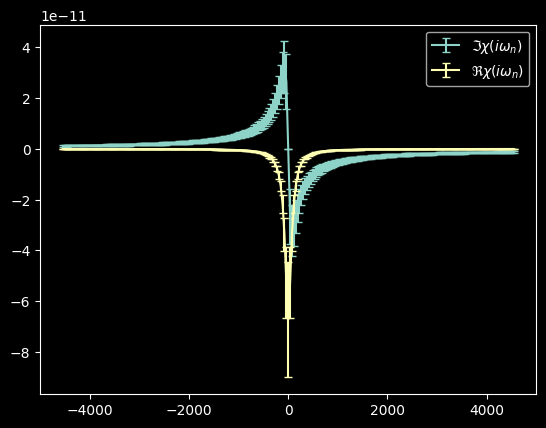

In [809]:
# this plots the w-dependence of the imfreq susceptibility at Gamma
iwdata=np.zeros((len(iOmesh),2), dtype=complex)

for n in range(-120, 121):
    val, error = quad(lambda w: chiGamma(w)/(2.0j*pi*n/iwmesh.beta-w)/pi,0,120,complex_func=True)
    iwdata[n+120,0] = val
    iwdata[n+120,1] = error
plt.errorbar([iw.imag for iw in iOmesh], np.imag(iwdata)[:,0], yerr=np.imag(iwdata)[:,1], label=r'$\Im \chi(i\omega_n)$', capsize=3)
plt.errorbar([iw.imag for iw in iOmesh], np.real(iwdata)[:,0], yerr=np.real(iwdata)[:,1], label=r'$\Re \chi(i\omega_n)$', capsize=3)
# plt.xlim(100,140)
plt.legend()
plt.show()

In [85]:
# # first we calculate the inverse fourier transform of the susceptibility by integrating over w

# def chiGamma_t(t):
#     val, error = quad(lambda w: chiGamma(w) * np.exp(-1.0j * w * t), -np.inf, np.inf, complex_func=True)
#     # print(abs(error)/abs(val))
#     # print(val)
#     return val

# print(chiGamma_t(0.1))
# # t_values = np.linspace(-1, 1, 1000)
# # chiGamma_t_values = [quad(lambda w: chiGamma(w) * np.exp(-1.0j * w * t), -np.inf, np.inf, complex_func=True)[0] for t in t_values]
# # plt.plot(t_values, np.real(chiGamma_t_values))


(-0.1081160075047247+0.02537272502255547j)


In [12]:
# now we define the vertex function
# For convenience we define the Vertex function in the order used in triqs_tprf (time, space) not (space, time) which is callable
iOkmesh = MeshProduct(iOmesh, kmesh)
Vertex = Gf(mesh=iOkmesh, target_shape=[4,4,4,4])
Vertex.data[:] = np.einsum('Oq,ab,cd->qOabcd',chi_expt_kiO.data,np.eye(4),np.eye(4))
Vertex.data[:] = g**2 * Vertex.data

In [98]:
# # then we calculate the imaginary time fourier transform (laplace transform) of the real time susceptibility

# def chiGamma_iw(n, beta):
#     if n>0:
#         return quad(lambda t: 1.0j/pi*chiGamma_t(t) * np.exp(-2.0*pi*n*t/beta), 0, np.inf, complex_func=True)
#     elif n<0:
#         return quad(lambda t: -1.0j/pi*chiGamma_t(t) * np.exp(-2.0*pi*n*t/beta), -np.inf, 0, complex_func=True)
#     else:
#         return quad(lambda w: -1.0/pi*chiGamma(w)/w, -np.inf, np.inf, complex_func=True)


In [99]:
# after doing all this, we find that the error bars are not really reduced by much, just a factor of 3 or so
# val,err=chiGamma_iw(1, iwmesh.beta)
# print(val)
# print(err/abs(val))
# val,err=chiGamma_iw(10, iwmesh.beta)
# print(val)
# print(err/abs(val))
# val,err=chiGamma_iw(100, iwmesh.beta)
# print(val)
# print(err/abs(val))


# w_values = np.linspace(0, 120, 1000)
# chiGamma_w_values = [chiGamma(w) for w in w_values]
# plt.plot(w_values, np.real(chiGamma_w_values))
# plt.show()


/home/tamag/.local/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:445: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
/home/tamag/.local/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:448: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  proba

(6.385457618141485e-05-2.631608161138605e-05j)
(0.01884810064668573+0.01888795512283537j)
(1.1358764156047303e-05+2.8616368896278865e-05j)
(0.00043592438823963767+0.00018950260972669427j)
(6.515723720681262e-09+3.2253715617136716e-06j)
(0.003993952537748709+0.00039931691590188866j)


2\) the susceptibility => chi_expt_kiO(k,i0) ☑️

And the vertex function => Vertex(i0,k) related by

$\chi_{expt}(k,i\Omega_n) = \sigma^0_{ab}V_{abcd}(i\Omega_n,k)\sigma^0_{cd}$
☑️

Now we move on to 3) the self-energy from the vertex and the bare Green's function

$\Sigma_{dc} (i\omega_l,k) = \sum_{n,q} G_{ab}(i\omega_l-i\Omega_n,k-q) V_{abcd}(i\Omega_n,q)$

this is a convolution in w,k space, hence just a product in r,$\tau$ space.

$\Sigma_{dc} (\tau,r) = G_{ab}(\tau,r) V_{abcd}(\tau,r)$



In [13]:
#define G_taur - the iFFT of g0_iwk

#define the real space mesh corresponding to the k-mesh
rmesh = MeshCyclicLattice(BL, n_k)
taumesh = MeshImTime(beta=iwmesh.beta, S='Fermion', n_max=6*n_iw+1)

# for each k do the fourier transform to imaginary time
tails_container = [None]*(n_k*n_k)
for i, k in tqdm(enumerate(kmesh)):
    tails_container[i] = g0_iwk[:,k].fit_tail()
G_ktau = Gf(mesh=MeshProduct(kmesh, taumesh), target_shape=[4,4])
for i,k in tqdm(enumerate(kmesh)):
    G_ktau[k,:] << Fourier(g0_iwk[:,k], known_moments=np.array(tails_container[i][0]))

#for each tau do the fourier transform to real space
G_taur = Gf(mesh=MeshProduct(taumesh, rmesh), target_shape=[4,4])
transformed_data = np.fft.ifft2(G_ktau.data.reshape(n_k, n_k, *G_ktau.data.shape[1:]), axes=(0, 1))
transformed_data = transformed_data.reshape(*G_ktau.data.shape).transpose(1,0,2,3)
G_taur.data[:] = transformed_data

256it [00:00, 404.53it/s]
256it [00:09, 27.59it/s]


(0.0002608471658535811+0j)
2.0038336515426636e-05
6.254194886423647e-07
0.0002608471658535811


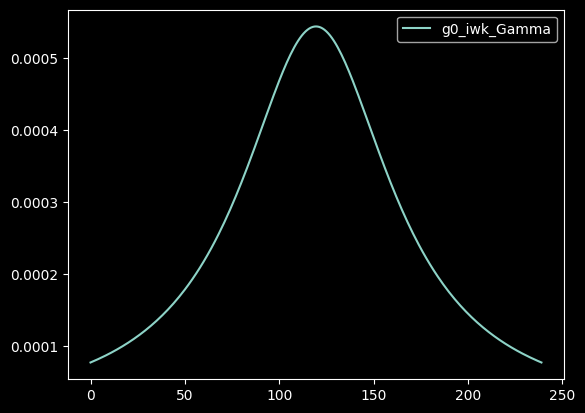

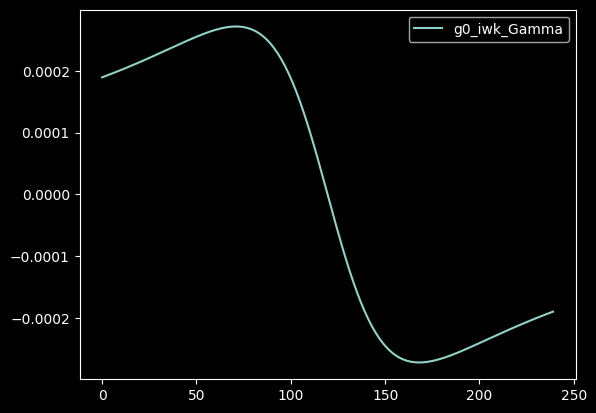

In [927]:
# try doing the Fourier transform to Gtauk manually and compare with G_ktau

#isolate g0_iwk for a given k =Gamma
g0_iwk_Gamma = g0_iwk.data[:,0,0,0]
#plot
# plt.plot(g0_iwk_Gamma.real, label='real')
#shift the data so that the zero frequency is at the centre
g0_iwk_Gamma_shifted = np.fft.fftshift(g0_iwk_Gamma)
#plot 
# plt.plot(g0_iwk_Gamma_shifted.real, label='real')
# plt.plot(g0_iwk_Gamma_shifted.imag, label='imag')
# plt.legend()
print(g0_iwk_Gamma_shifted.mean())
#do the fourier transform
Gtauk_Gamma = np.fft.ifft(g0_iwk_Gamma_shifted)

#check that it is the same as G_ktau by plotting them
# plt.plot(Gtauk_Gamma.real, label='Gtauk_Gamma')
# plt.show()
# plt.plot(G_ktau.data[0,:,0,0].real, label='G_ktau')
# plt.legend()
# plt.show()
#they're clearly not the same
print(G_ktau.data[0,120,0,0].real)
print(G_ktau.data[0,120,0,0].imag)
print(Gtauk_Gamma[0].real)
# let's take the fourier transform of both of them to see which one is correct
Gtauk_Gamma_shifted = np.fft.fftshift(Gtauk_Gamma)
Giwk_Gamma = np.fft.fft(Gtauk_Gamma_shifted)

G_ktau_shifted = np.fft.fftshift(G_ktau.data[0,:,0,0])
G_iwktau = np.fft.fft(G_ktau_shifted)

# plt.plot(Giwk_Gamma.real, '-',label='Giwk_Gamma')
# plt.plot(G_iwktau.real, '-' ,label='G_iwktau')   
plt.plot(g0_iwk_Gamma.real, '-', label='g0_iwk_Gamma')
plt.legend()
plt.show()
# plt.plot(Giwk_Gamma.imag, '-',label='Giwk_Gamma')
# plt.plot(G_iwktau.imag, '-' ,label='G_iwktau')   
plt.plot(g0_iwk_Gamma.imag, '-', label='g0_iwk_Gamma')
plt.legend()

#residual old code that may be useless, moving forward

# # rmesh = MeshCyclicLattice(BL, n_k)
# # taumesh = MeshImTime(beta=iwmesh.beta, S='Fermion', n_max=6*n_iw+1)
# G_ktau2 = Gf(mesh=MeshProduct(kmesh, taumesh), target_shape=g0_iwk.target_shape)

# # now fit the tails at each k
# tails_container = [None]*(n_k*n_k)
# for i, k in enumerate(kmesh):
#     tails_container[i] = g0_iwk[:,k].fit_tail()
#     G_ktau2[k,:].data[:] = make_gf_from_fourier(g0_iwk[:,k], mesh=taumesh, known_moments=np.array(tails_container[i][0])).data

# g0_iwk_from_fit = Gf(mesh=g0_iwk.mesh, target_shape=g0_iwk.target_shape)
# for i, k in enumerate(kmesh):
#     g0_iwk_from_fit[:,k].data[:] = make_gf_from_fourier(G_ktau[k,:]).data

# np.allclose(g0_iwk.data, g0_iwk_from_fit.data)





Ok, so we identified a problem that needs to be addressed. Fit the Green's function tail separately if it is gapless.

For demonstration, let's do this on a simple toy Green's function $(iw_n -0.02)^{-1}$

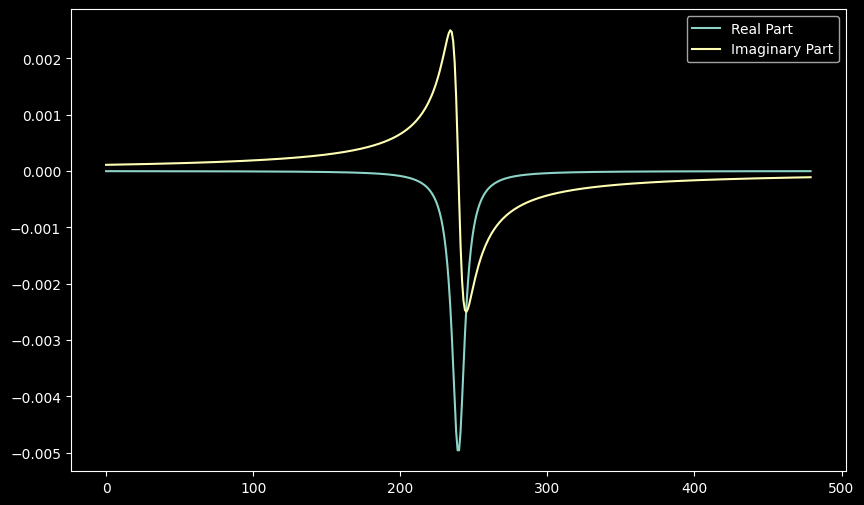

In [1127]:
# define a new ImFreq mesh
iwmesh2 = MeshImFreq(beta=1.0/(K_B*T), S='Fermion', n_iw=240) #needs to have enough meshpoints or else make_gf_from_fourier will fail later

#define a simple Gf on the new mesh
G_iwmesh2 = Gf(mesh=iwmesh2, target_shape=[]) 
G_iwmesh2 << iOmega_n - 200
G_iwmesh2.invert()
# oplot(G_iwmesh2,'o-')

G_iwmesh2_data = G_iwmesh2.data
plt.figure(figsize=(10, 6))
plt.plot(G_iwmesh2_data.real, label='Real Part')
plt.plot(G_iwmesh2_data.imag, label='Imaginary Part')
plt.legend()
plt.show()




In [1291]:
# fit the tail of this Gf
G_iwmesh2_tail, err = G_iwmesh2.fit_tail()
# now get a green's function from the fourier transform using the tails
taumesh2= MeshImTime(beta=iwmesh2.beta, S='Fermion', n_tau=480*3+1)
G_taumesh2= make_gf_from_fourier(G_iwmesh2, mesh=taumesh2, known_moments=G_iwmesh2_tail)
#now invert the fourier transforms 
G_iwmesh2_from_fit= make_gf_from_fourier(G_taumesh2)

print("iw mesh points before fit",G_iwmesh2.data.shape)
print("tau mesh points after fit",G_taumesh2.data.shape)
print("iw mesh points after fit",G_iwmesh2_from_fit.data.shape)

iw mesh points before fit (480,)
tau mesh points after fit (1441,)
iw mesh points after fit (480,)


In [1200]:
G_iwmesh2_tail

array([-1.15783666e-12+6.12682648e-16j,  1.00000000e+00-2.01873191e-10j,
        1.99999772e+02+8.04508679e-08j,  3.99999539e+04-2.63666049e-02j,
        7.98512515e+06+2.61609166e+00j,  1.59701216e+09-8.52601957e+05j])

In [1129]:
assert np.allclose(G_iwmesh2.data, G_iwmesh2_from_fit.data)

In [1308]:
abs((G_ktau.data- G_ktau2.data)).max() # this is the extent of error we get from not fitting the tails separately, negligible at this point

1.3184907535028515e-06

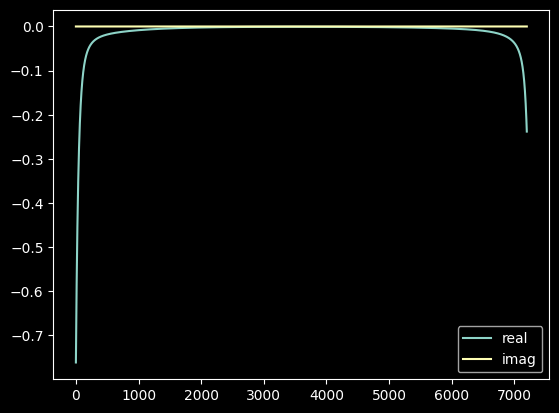

In [1313]:
# imaginary time plot of G(r=0)
plt.plot(transformed_data[:,0,0,0].real, label='real')
plt.plot(transformed_data[:,0,0,0].imag, label='imag')
plt.legend()

This looks right $G(\tau=0^+)+G(\tau=\beta^-)=1$

In [16]:
#don't run this yet, code crashes the kernel
# check the time taken above
#define Vertex_rtau - the iFFT of Vertex 

taumeshBoson=make_gf_from_fourier(Gf(mesh=iOmesh, data=Vertex.data[:,0,0,0,0,0])).mesh


In [17]:
iOmesh

Matsubara Freq Mesh of size 2401, Domain: Matsubara domain with beta = 0.165779, statistic = Boson, positive_only : 0

In [17]:
taumeshBoson

Imaginary Time Mesh of size 727, Domain: Matsubara domain with beta = 0.165779, statistic = Boson

In [30]:
n_iw*6

1200

In [31]:
MeshImTime(beta=taumeshBoson.beta,S='Boson',n_tau=n_iw+1)

Imaginary Time Mesh of size 1201, Domain: Matsubara domain with beta = 0.165779, statistic = Boson

In [44]:
np.array([tau.value for tau in taumeshBoson])[::6].shape
    

(1202,)

In [37]:
Vtau.data.shape

(7207,)

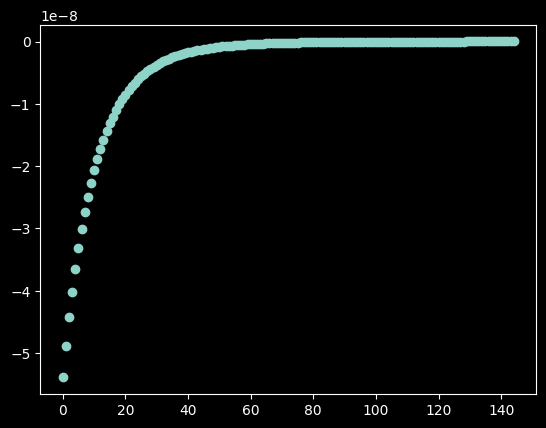

In [28]:
#first check out the tau dependence of the vertex at GammaV
Vtau=make_gf_from_fourier(Gf(mesh=iOmesh, data=chi_expt_kiO.data[2,:]))
plt.plot(Vtau.data.real[::50],'o')
# plt.xlim(0,taumeshBoson.beta/2.)
# looks like less discrete sampling is a good idea

In [17]:
# next try to ft chi_expt_kiO first and then elevate it to a rank-4 matrix later
taumeshBoson=make_gf_from_fourier(Gf(mesh=iOmesh, data=chi_expt_kiO.data[0,:])).mesh
gc.collect()
chi_expt_ktau = Gf(mesh=MeshProduct(kmesh, taumeshBoson), target_shape=[])
for kid, k in tqdm(enumerate(kmesh)):
    chi_expt_ktau.data[kid,:] = make_gf_from_fourier(chi_expt_kiO[k,:]).data

256it [00:01, 159.92it/s]


In [13]:
# now we define the vertex function in imaginary time
taukmesh = MeshProduct(taumeshBoson, kmesh)
Vertex_tauk = Gf(mesh=taukmesh, target_shape=[4,4,4,4])
Vertex_tauk.data[:] = np.einsum('Oq,ab,cd->qOabcd',chi_expt_ktau.data,np.eye(4),np.eye(4))
Vertex_tauk.data[:] = g**2 * Vertex_tauk.data

: 

The problem here is that the data a 7207x16x16x4x4x4x4 array of complex numbers - this is about 7gb and my RAM is 16gb, out of which half is probably used. The solution is to transform to a smaller mesh, the vertex function is probably small and decay fast in $\tau$ space.

Resolved below by sampling every sixth tau point

In [45]:
taumeshBoson = MeshImTime(beta=iwmesh.beta, S='Boson', n_max=n_iw+2)  #n_iw*6+1)
Vertex_ktau = Gf(mesh=MeshProduct(kmesh, taumeshBoson), target_shape=[4,4,4,4])
import gc
gc.collect()
for kid, k in tqdm(enumerate(kmesh)):
    Vertex_ktau.data[kid,:] = make_gf_from_fourier(Gf(mesh=iOmesh, data=Vertex.data[:,kid])).data[::6]
    gc.collect()


256it [01:34,  2.71it/s]


In [25]:
for kid, k in tqdm(enumerate(kmesh)):
    # print(make_gf_from_fourier(Vertex[:,k]).data.shape)
    Vertex_ktau.data[kid,:] = make_gf_from_fourier(Gf(mesh=iOmesh, data=Vertex.data[:,kid])).data
    # del(temp)
    gc.collect()
    # Vertex_tau_Gamma = make_gf_from_fourier(Vertex_Gamma_iw)
    # try make_gf_from_fourier that seemed to have worked before
    # make temp variables to be able to exactly follow the code below that worked
    # if not, just fourier transform the data nparray manually


0it [00:00, ?it/s]

256it [00:13, 18.81it/s]


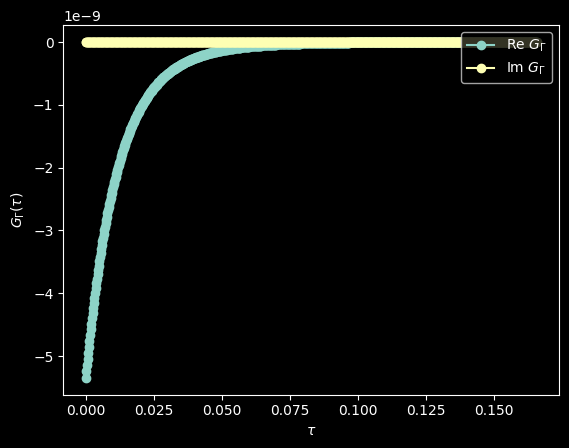

In [26]:
oplot(Gf(mesh=taumeshBoson, data=Vertex_ktau.data[0,:,0,0,0,0], name=r'$G_{\Gamma}$'),'o-')

In [46]:
# first we need to shift the data so that the zero frequency is at the beginning
# next we need to do the fourier transform over the frequency axis
# and store only the time-slices from 0 to beta inclusive
#### start from here tomorrow, replace this with the native fourier transform in triqs
# Vertex_ktau.data[:] = np.fft.ifft(np.fft.fftshift(Vertex.data, axes=(0)),axis =(0)).transpose(1,0,2,3,4,5)

#for each tau do the fourier transform to real space
Vertex_taur = Gf(mesh=MeshProduct(taumeshBoson, rmesh), target_shape=[4,4,4,4])
transformed_data = np.fft.ifft2(Vertex_ktau.data.reshape(n_k, n_k, *Vertex_ktau.data.shape[1:]), axes=(0, 1))
transformed_data = transformed_data.reshape(*Vertex_ktau.data.shape).transpose(1,0,2,3,4,5)
Vertex_taur.data[:] = transformed_data

# need to check the normalization since I did the fourier transform manually
# check with earlier FT of Green's function since 

In [47]:
# now we mush check 1) alignment of the tau meshes
# 2) plot the two on top: vertex and g0_tau
# 3) lattice_dyson_g_wk will not work, it takes a k-indep Sigma, so FT(Sigma), add to go_iwk and get g_iwk
?lattice_dyson_g_wk

Docstring:
Construct an interacting Matsubara frequency lattice Green's function :math:`G_{a\bar{b}}(i\omega_n, \mathbf{k})`

 Computes

 .. math::
    G_{a\bar{b}}(i\omega_n, \mathbf{k}) = \left[
        (i\omega_n + \mu ) \cdot \mathbf{1}  - \epsilon(\mathbf{k}) - \Sigma(i\omega_n)
        \right]^{-1}_{a\bar{b}},

 using a discretized dispersion :math:`\epsilon_{\bar{a}b}(\mathbf{k})`,
 chemical potential :math:`\mu`, and a momentum independent Matsubara frequency
 self energy :math:`\Sigma_{\bar{a}b}(i\omega_n)`.

Parameters
----------
mu
     chemical potential :math:`\mu`

e_k
     discretized lattice dispersion :math:`\epsilon_{\bar{a}b}(\mathbf{k})`

sigma_w
     imaginary frequency self-energy :math:`\Sigma_{\bar{a}b}(i\omega_n)`

Returns
-------
out
     Matsubara frequency lattice Green's function :math:`G_{a\bar{b}}(i\omega_n, \mathbf{k})`


Signature : (float mu, triqs_tprf::e_k_cvt e_k, triqs_tprf::g_w_cvt sigma_w) -> triqs_tprf::g_wk_t
   Construct an interacting Matsuba

In [35]:
#we want to be sure of the fourier transform of the vertex to imaginary time
#first isolate a green's function at k=Gamma and the 0,0,0,0 component
taumeshBoson = MeshImTime(beta=iwmesh.beta, S='Boson', n_max=241)
Vertex_Gamma_iw = Gf(mesh=iOmesh, data=Vertex.data[:,156,0,0,0,0])
#plot
# oplot(Vertex_Gamma_iw,'o-')
#looks like it decayed fast enoough, let's do the fourier transform
# tauBosonmesh=make_gf_from_fourier(Vertex_Gamma_iw).mesh
# Vertex_tau_Gamma =Gf(mesh=taumeshBoson, target_shape=[])
# make_gf_from_fourier(Vertex_Gamma_iw, mesh=taumeshBoson).data
Vertex_tau_Gamma = make_gf_from_fourier(Vertex_Gamma_iw)
#for whatever reason, the tau mesh is a weird size = 727 for n_iw=120 and n_iO=2*n_iw+1

In [36]:
Vertex_tau_Gamma.data.shape

(7207,)

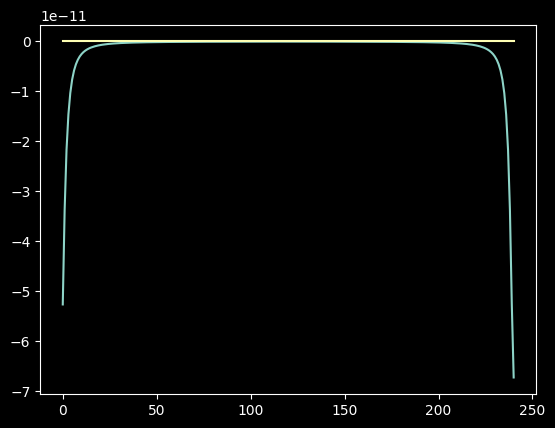

In [890]:
#debugging Vertex_taur

#first isolate the Vertex at a given k = Gamma
Vertex_Gamma = Vertex.data[:,0,0,0,0,0]
#then do the fourier transform to imaginary time
#only after shifting the data so that the zero frequency is at the beginning
Vertex_Gamma_tau = np.fft.ifft(np.fft.fftshift(Vertex_Gamma, axes=(0)))
#plot this 
plt.plot(np.fft.fftshift(Vertex_Gamma.real))
plt.plot(Vertex_Gamma_tau.real*K_B*T*241*0)

# Vertex_Gamma_tau.shape


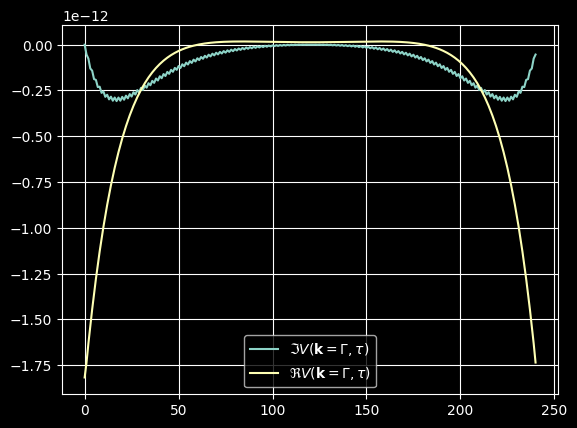

In [841]:
# imaginary time plot of vertex at Gamma
plt.plot(np.fft.ifft(np.fft.fftshift(Vertex.data[:,0,0,0,0,0].imag)),label=r'$\Im V(\mathbf{k}=\Gamma,\tau)$')
plt.plot(np.fft.ifft(np.fft.fftshift(Vertex.data[:,0,0,0,0,0].real)),label=r'$\Re V(\mathbf{k}=\Gamma,\tau)$')
plt.legend()
plt.grid(True)

In [585]:
# check alignment of the imaginary time meshes taumesh and taumeshBoson
print(np.array(list(taumesh.values())))
print(np.array(list(taumeshBoson.values())))

[0.         0.00069075 0.00138149 0.00207224 0.00276298 0.00345373
 0.00414447 0.00483522 0.00552596 0.00621671 0.00690745 0.0075982
 0.00828894 0.00897969 0.00967043 0.01036118 0.01105192 0.01174267
 0.01243341 0.01312416 0.0138149  0.01450565 0.01519639 0.01588714
 0.01657788 0.01726863 0.01795937 0.01865012 0.01934086 0.02003161
 0.02072235 0.0214131  0.02210384 0.02279459 0.02348533 0.02417608
 0.02486682 0.02555757 0.02624831 0.02693906 0.02762981 0.02832055
 0.0290113  0.02970204 0.03039279 0.03108353 0.03177428 0.03246502
 0.03315577 0.03384651 0.03453726 0.035228   0.03591875 0.03660949
 0.03730024 0.03799098 0.03868173 0.03937247 0.04006322 0.04075396
 0.04144471 0.04213545 0.0428262  0.04351694 0.04420769 0.04489843
 0.04558918 0.04627992 0.04697067 0.04766141 0.04835216 0.0490429
 0.04973365 0.05042439 0.05111514 0.05180588 0.05249663 0.05318737
 0.05387812 0.05456886 0.05525961 0.05595036 0.0566411  0.05733185
 0.05802259 0.05871334 0.05940408 0.06009483 0.06078557 0.061476

In [854]:
# get SelfEn by multiplying g0_iwk and Vertex in real space and time
SelfEn_taur = Gf(mesh=MeshProduct(taumesh, rmesh), target_shape=[4,4])
SelfEn_taur.data[:] = np.einsum('trab,trabcd->trdc',G_taur.data,Vertex_taur.data)

# and then do the fourier transform to Matsubara frequency
iwmesh_large= MeshImFreq(beta=1.0/(K_B*T), S='Fermion', n_iw=120)
SelfEn_iwr = Gf(mesh=MeshProduct(iwmesh_large,rmesh), target_shape=[4,4])
# np.fft.ifft(np.fft.fftshift(Vertex.data, axes=(0)),axis =(0)).transpose(1,0,2,3,4,5)
# np.fft.fft()
for r in rmesh:
    SelfEn_iwr[:,r] << Fourier(SelfEn_taur[:,r])
 
# and then do the fourier transform to k space
SelfEn_iwk = Gf(mesh=MeshProduct(iwmesh,kmesh), target_shape=[4,4])
transformed_data = SelfEn_iwr.data.transpose(1,0,2,3) # swap the space and frequency axes
transformed_data = np.fft.fft2(transformed_data.reshape(16, 16, *transformed_data.shape[1:]), axes=(0, 1))
SelfEn_iwk.data[:] = transformed_data.reshape((256,240,4,4)).transpose(1,0,2,3)

[Direct Fourier] WARNING: The imaginary time mesh is less than six times as long as the number of positive frequencies.
This can lead to substantial numerical inaccuracies at the boundary of the frequency mesh.
[Direct Fourier] WARNING: The imaginary time mesh is less than six times as long as the number of positive frequencies.
This can lead to substantial numerical inaccuracies at the boundary of the frequency mesh.
[Direct Fourier] WARNING: The imaginary time mesh is less than six times as long as the number of positive frequencies.
This can lead to substantial numerical inaccuracies at the boundary of the frequency mesh.
[Direct Fourier] WARNING: The imaginary time mesh is less than six times as long as the number of positive frequencies.
This can lead to substantial numerical inaccuracies at the boundary of the frequency mesh.
[Direct Fourier] WARNING: The imaginary time mesh is less than six times as long as the number of positive frequencies.
This can lead to substantial numeric

$\Sigma$ and $V$ are not sanity-checked yet. Vertex function at r=0 (local) does seem to have some wiggles that I don't understand. Ok, now I understand it better, the fourier transform over iwn that was done manually is suspect.

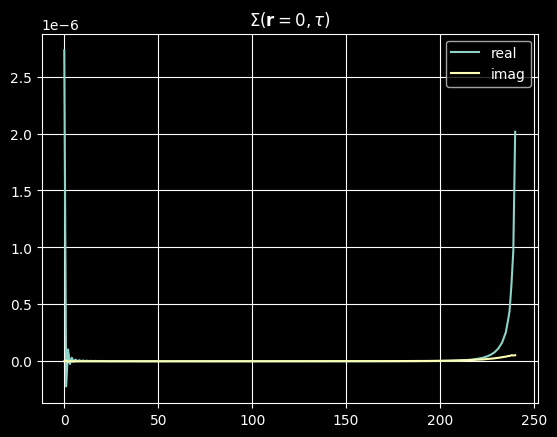

In [864]:
# imaginary time plot of SelfEn at r=0
plt.plot(SelfEn_taur.data[:,0,0,0].real,label='real')
plt.plot(SelfEn_taur.data[:,0,0,0].imag,label='imag')
# plt.xlim(0,20)
plt.title(r'$\Sigma(\mathbf{r}=0,\tau)$')
plt.grid(True)
plt.legend()


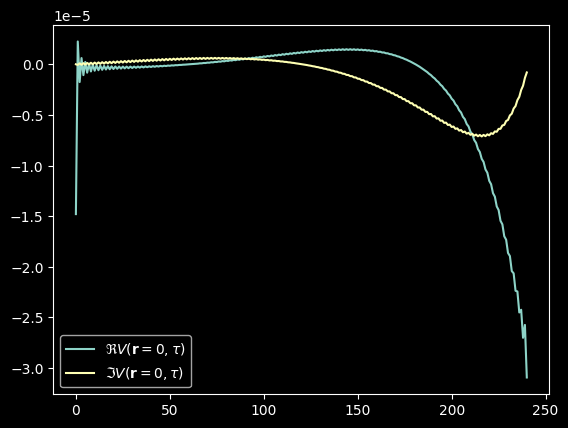

In [869]:
# to make sense of this plot, plot the trace of g0_taur at r=0 and Vertex_taur at r=0 over the imaginary time mesh
# sum G_taur.data[:,0,i,i] over i
# plt.plot(np.sum(G_taur.data[:,0,:,:],axis=(1,2)).real,label=r'$\Re G(\mathbf{r}=0,\tau)$')
# plt.plot(np.sum(G_taur.data[:,0,:,:],axis=(1,2)).imag,label=r'$\Im G(\mathbf{r}=0,\tau)$')
#same for Vertex_taur
plt.plot(np.sum(Vertex_taur.data[:,0,:,:,:,:],axis=(1,2,3,4)).real,label=r'$\Re V(\mathbf{r}=0,\tau)$')
plt.plot(np.sum(Vertex_taur.data[:,0,:,:,:,:],axis=(1,2,3,4)).imag,label=r'$\Im V(\mathbf{r}=0,\tau)$')
#same for SelfEn_taur
# plt.plot(np.sum(SelfEn_taur.data[:,0,:,:],axis=(1,2)).real,label=r'$\Re \Sigma(\mathbf{r}=0,\tau)$')
# plt.plot(np.sum(SelfEn_taur.data[:,0,:,:],axis=(1,2)).imag,label=r'$\Im \Sigma(\mathbf{r}=0,\tau)$')
plt.legend()

looks like the Vertex function is suspect. check out the frequency dependence of the vertex function. 

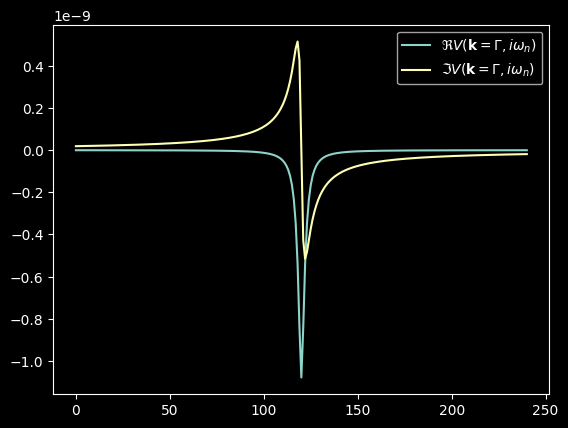

In [872]:
# plot the Matsuabara frequency dependence of the Vertex at Gamma
# trace over the orbital indices
plt.plot(np.sum(Vertex.data[:,0,:,:,:,:].real,axis=(1,2,3,4)),label=r'$\Re V(\mathbf{k}=\Gamma,i\omega_n)$')
plt.plot(np.sum(Vertex.data[:,0,:,:,:,:].imag,axis=(1,2,3,4)),label=r'$\Im V(\mathbf{k}=\Gamma,i\omega_n)$')
plt.legend()
 

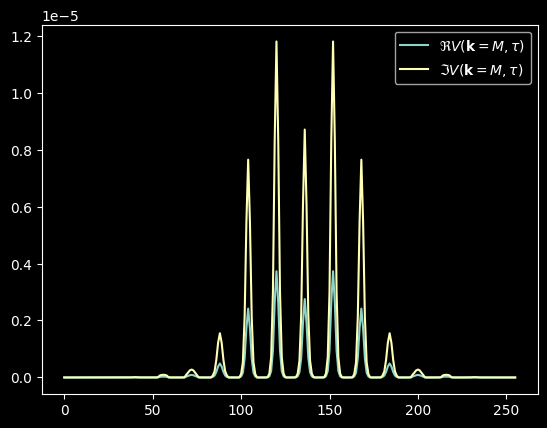

In [877]:
#similarly plot Vertex_ktau at Gamma
# plt.plot(np.sum(Vertex_ktau.data[:,0,:,:,:,:].real,axis=(1,2,3,4)),label=r'$\Re V(\mathbf{k}=\Gamma,\tau)$')
# plt.plot(np.sum(Vertex_ktau.data[:,0,:,:,:,:].imag,axis=(1,2,3,4)),label=r'$\Im V(\mathbf{k}=\Gamma,\tau)$')
#similarly plot Vertex_ktau at M
plt.plot(np.sum(Vertex_ktau.data[:,8*8+8,:,:,:,:].real,axis=(1,2,3,4)),label=r'$\Re V(\mathbf{k}=M,\tau)$')
plt.plot(np.sum(Vertex_ktau.data[:,8*8+8,:,:,:,:].imag,axis=(1,2,3,4)),label=r'$\Im V(\mathbf{k}=M,\tau)$')
plt.legend()


Interestingly, almost no Imaginary part in the vertex function in imaginary time. Even though in Matsubara frequency, the vertex is complex.

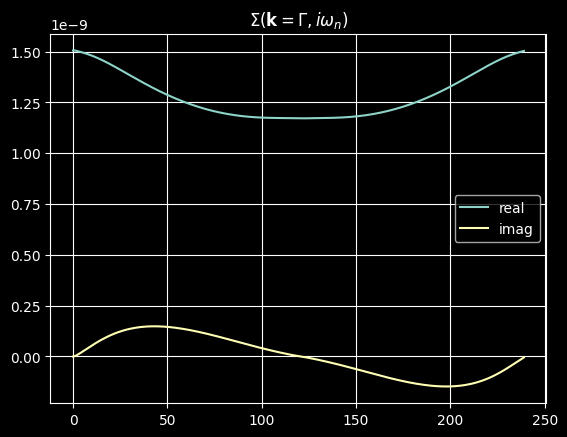

In [858]:

# imaginary frequency plot of SelfEn at k=Gamma
plt.plot(SelfEn_iwk.data[:,0,0,0].real, label='real')
plt.plot(SelfEn_iwk.data[:,0,0,0].imag, label='imag')
plt.title(r'$\Sigma(\mathbf{k}=\Gamma,i\omega_n)$')
plt.grid()
plt.legend()


In [849]:
SelfEn_iwr.data.shape

(240, 256, 4, 4)

In [851]:
SelfEn_iwr.data[0,0,0,0]

(9.050102268659874e-10-2.0866787091770394e-11j)

In [848]:
print(np.abs(Vertex.data).max(),np.abs(Vertex.data).min())

0.0005546872639873632 0.0


In [ ]:
# need to understand why chi_expt_kiO.data has NaN values

# find 